In [ ]:
# !pip3 -qq install torch==0.4.1
#!pip install bokeh==0.13.0
#!pip install gensim==3.6.0
#!pip install nltk

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети, часть 2

## POS Tagging

Мы уже посмотрели на применение рекуррентных сетей для классификации.

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg " ")

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Перейдем к ещё одному варианту - sequence labeling (последняя картинка).

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /home/alexander/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [3]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [4]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [5]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADJ', 'PRON', 'NOUN', 'ADV', 'CONJ', 'NUM', '.', 'PRT', 'VERB', 'DET', 'X', 'ADP'}


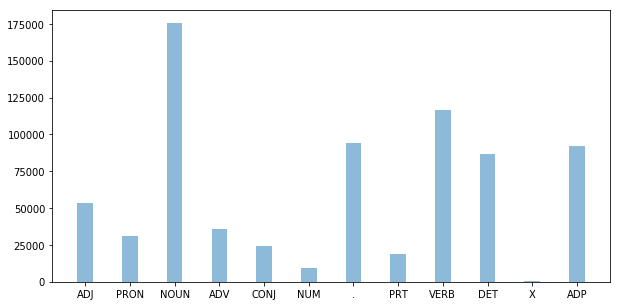

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png " ")  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [7]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [8]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [9]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png " ")

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [10]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [11]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [12]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch, y_batch

(array([[12117., 10563., 37682., 43738.],
        [24561., 44054., 39575., 32846.],
        [25542., 39530., 31529., 12069.],
        [43738., 20292., 28826., 23651.],
        [ 2735., 16409., 25542., 39530.],
        [39530.,  6202.,  6159.,  3519.],
        [43738.,  7288., 39530., 11441.],
        [26247., 27813., 18150., 35823.],
        [25344., 16802., 37359., 29200.],
        [17727., 43738., 43738., 44825.],
        [39530., 44774., 21504., 39530.],
        [ 9621.,  4128., 16331., 29200.],
        [38662., 39530., 43738., 29334.],
        [42193., 42842., 32492., 28399.],
        [    0.,  8695., 11200., 33513.],
        [    0.,  5802., 39530., 36170.],
        [    0., 17941., 43738., 39575.],
        [    0., 16331., 17439., 21101.],
        [    0., 43738., 16331., 17187.],
        [    0., 36009., 10656., 19731.],
        [    0., 16331., 16063., 25542.],
        [    0.,   234.,  5208., 27647.],
        [    0., 42193., 15805., 42193.],
        [    0.,     0., 14429.,  

**Задание** Реализуйте `LSTMTagger`:

In [13]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count,)
        self.lin = nn.Linear(lstm_hidden_dim, len(tag2ind))

    def forward(self, inputs):
        x = self.emb(inputs)
        x, hidden = self.lstm(x)
        x = self.lin(x)
        return x

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [14]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

def get_accuracy(logits, target):
    preds = torch.argmax(torch.sigmoid(logits), dim =2).reshape(-1)
    y_true = target.reshape(-1)
    return ((y_true == preds).float()*(y_true != 0).float()).sum(), (y_true != 0).float().sum()
    
get_accuracy(logits, y_batch)

(tensor(2.), tensor(92.))

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
loss = criterion(logits.reshape((-1, len(tag2ind))), y_batch.reshape(-1))

**Задание** Вставьте эти вычисление в функцию:

In [16]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.reshape((-1, len(tag2ind))), y_batch.reshape(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = get_accuracy(logits, y_batch)
                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [17]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.31694, Accuracy = 71.41%: 100%|██████████| 572/572 [00:05<00:00, 99.05it/s] 
[1 / 50]   Val: Loss = 0.10786, Accuracy = 84.91%: 100%|██████████| 13/13 [00:00<00:00, 82.28it/s]
[2 / 50] Train: Loss = 0.10155, Accuracy = 89.85%: 100%|██████████| 572/572 [00:05<00:00, 99.89it/s] 
[2 / 50]   Val: Loss = 0.07664, Accuracy = 89.60%: 100%|██████████| 13/13 [00:00<00:00, 83.10it/s]
[3 / 50] Train: Loss = 0.06807, Accuracy = 93.16%: 100%|██████████| 572/572 [00:05<00:00, 101.07it/s]
[3 / 50]   Val: Loss = 0.07008, Accuracy = 91.28%: 100%|██████████| 13/13 [00:00<00:00, 77.28it/s]
[4 / 50] Train: Loss = 0.05095, Accuracy = 94.79%: 100%|██████████| 572/572 [00:05<00:00, 102.23it/s]
[4 / 50]   Val: Loss = 0.06625, Accuracy = 92.27%: 100%|██████████| 13/13 [00:00<00:00, 85.95it/s]
[5 / 50] Train: Loss = 0.04101, Accuracy = 95.80%: 100%|██████████| 572/572 [00:05<00:00, 99.46it/s] 
[5 / 50]   Val: Loss = 0.06756, Accuracy = 92.80%: 100%|██████████| 13/13 [00:00<00:00, 82.08i

[41 / 50] Train: Loss = 0.00175, Accuracy = 99.76%: 100%|██████████| 572/572 [00:05<00:00, 98.33it/s]  
[41 / 50]   Val: Loss = 0.15788, Accuracy = 92.92%: 100%|██████████| 13/13 [00:00<00:00, 81.73it/s]
[42 / 50] Train: Loss = 0.00212, Accuracy = 99.71%: 100%|██████████| 572/572 [00:05<00:00, 96.95it/s]  
[42 / 50]   Val: Loss = 0.17239, Accuracy = 93.09%: 100%|██████████| 13/13 [00:00<00:00, 88.59it/s]
[43 / 50] Train: Loss = 0.00143, Accuracy = 99.79%: 100%|██████████| 572/572 [00:05<00:00, 100.90it/s] 
[43 / 50]   Val: Loss = 0.16384, Accuracy = 93.11%: 100%|██████████| 13/13 [00:00<00:00, 82.63it/s]
[44 / 50] Train: Loss = 0.00125, Accuracy = 99.80%: 100%|██████████| 572/572 [00:05<00:00, 100.88it/s] 
[44 / 50]   Val: Loss = 0.16262, Accuracy = 93.13%: 100%|██████████| 13/13 [00:00<00:00, 85.30it/s]
[45 / 50] Train: Loss = 0.00124, Accuracy = 99.81%: 100%|██████████| 572/572 [00:05<00:00, 98.42it/s]  
[45 / 50]   Val: Loss = 0.16167, Accuracy = 93.10%: 100%|██████████| 13/13 [00:0

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png " ")  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [18]:
class LSTMTaggerBidirectional(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional = True)
        self.lin = nn.Linear(lstm_hidden_dim*2, len(tag2ind))

    def forward(self, inputs):
        x = self.emb(inputs)
        x, hidden = self.lstm(x)
        x = self.lin(x)
        return x

In [20]:
model = LSTMTaggerBidirectional(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.25371, Accuracy = 76.52%: 100%|██████████| 572/572 [00:07<00:00, 79.30it/s]
[1 / 20]   Val: Loss = 0.07123, Accuracy = 89.57%: 100%|██████████| 13/13 [00:00<00:00, 65.47it/s]
[2 / 20] Train: Loss = 0.07577, Accuracy = 92.60%: 100%|██████████| 572/572 [00:07<00:00, 81.36it/s]
[2 / 20]   Val: Loss = 0.05010, Accuracy = 93.19%: 100%|██████████| 13/13 [00:00<00:00, 64.41it/s]
[3 / 20] Train: Loss = 0.04941, Accuracy = 95.29%: 100%|██████████| 572/572 [00:07<00:00, 81.22it/s]
[3 / 20]   Val: Loss = 0.04085, Accuracy = 94.56%: 100%|██████████| 13/13 [00:00<00:00, 70.57it/s]
[4 / 20] Train: Loss = 0.03493, Accuracy = 96.70%: 100%|██████████| 572/572 [00:07<00:00, 78.60it/s]
[4 / 20]   Val: Loss = 0.03634, Accuracy = 95.18%: 100%|██████████| 13/13 [00:00<00:00, 73.03it/s]
[5 / 20] Train: Loss = 0.02576, Accuracy = 97.58%: 100%|██████████| 572/572 [00:07<00:00, 80.25it/s]
[5 / 20]   Val: Loss = 0.03452, Accuracy = 95.53%: 100%|██████████| 13/13 [00:00<00:00, 67.30it/s]


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [21]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

Построим подматрицу для слов из нашей тренировочной выборки:

In [22]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [23]:
embeddings.shape

(45441, 100)

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [24]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding.from_pretrained(torch.Tensor(embeddings))
        self.lstm = nn.LSTM(w2v_model.vectors.shape[1], lstm_hidden_dim, lstm_layers_count)
        self.lin = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        x = self.emb(inputs)
        x, hidden = self.lstm(x)
        return self.lin(x)

In [26]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.75980, Accuracy = 77.67%: 100%|██████████| 572/572 [00:03<00:00, 143.19it/s]
[1 / 20]   Val: Loss = 0.37398, Accuracy = 88.83%: 100%|██████████| 13/13 [00:00<00:00, 106.30it/s]
[2 / 20] Train: Loss = 0.28850, Accuracy = 91.36%: 100%|██████████| 572/572 [00:04<00:00, 130.39it/s]
[2 / 20]   Val: Loss = 0.26221, Accuracy = 92.05%: 100%|██████████| 13/13 [00:00<00:00, 107.45it/s]
[3 / 20] Train: Loss = 0.21270, Accuracy = 93.37%: 100%|██████████| 572/572 [00:04<00:00, 143.81it/s]
[3 / 20]   Val: Loss = 0.21322, Accuracy = 93.24%: 100%|██████████| 13/13 [00:00<00:00, 112.14it/s]
[4 / 20] Train: Loss = 0.17584, Accuracy = 94.39%: 100%|██████████| 572/572 [00:03<00:00, 145.79it/s]
[4 / 20]   Val: Loss = 0.18785, Accuracy = 93.94%: 100%|██████████| 13/13 [00:00<00:00, 111.92it/s]
[5 / 20] Train: Loss = 0.15417, Accuracy = 94.97%: 100%|██████████| 572/572 [00:04<00:00, 137.57it/s]
[5 / 20]   Val: Loss = 0.17080, Accuracy = 94.43%: 100%|██████████| 13/13 [00:00<00:00, 10

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

In [ ]:
<calc test accuracy>

### Дообучение предобученных векторов

**Задание** Почему бы не попробовать дообучать вектора? Для этого нужно просто заменить флаг `freeze=False` в методе `from_pretrained`. Попробуйте.

In [27]:
class LSTMTaggerWithPretrainedEmbsNonFreeze(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding.from_pretrained(torch.Tensor(embeddings), freeze=False)
        self.lstm = nn.LSTM(w2v_model.vectors.shape[1], lstm_hidden_dim, lstm_layers_count)
        self.lin = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        x = self.emb(inputs)
        x, hidden = self.lstm(x)
        return self.lin(x)

In [29]:
model = LSTMTaggerWithPretrainedEmbsNonFreeze(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.53423, Accuracy = 84.76%: 100%|██████████| 572/572 [00:05<00:00, 100.83it/s]
[1 / 20]   Val: Loss = 0.16963, Accuracy = 94.70%: 100%|██████████| 13/13 [00:00<00:00, 113.35it/s]
[2 / 20] Train: Loss = 0.11610, Accuracy = 96.13%: 100%|██████████| 572/572 [00:05<00:00, 101.79it/s]
[2 / 20]   Val: Loss = 0.12865, Accuracy = 95.65%: 100%|██████████| 13/13 [00:00<00:00, 117.64it/s]
[3 / 20] Train: Loss = 0.08292, Accuracy = 97.09%: 100%|██████████| 572/572 [00:05<00:00, 102.36it/s]
[3 / 20]   Val: Loss = 0.11879, Accuracy = 95.91%: 100%|██████████| 13/13 [00:00<00:00, 118.91it/s]
[4 / 20] Train: Loss = 0.06753, Accuracy = 97.57%: 100%|██████████| 572/572 [00:05<00:00, 98.27it/s] 
[4 / 20]   Val: Loss = 0.11694, Accuracy = 96.05%: 100%|██████████| 13/13 [00:00<00:00, 101.72it/s]
[5 / 20] Train: Loss = 0.05791, Accuracy = 97.88%: 100%|██████████| 572/572 [00:05<00:00, 102.88it/s]
[5 / 20]   Val: Loss = 0.11846, Accuracy = 96.10%: 100%|██████████| 13/13 [00:00<00:00, 11

**Задание** На самом деле, понятно, почему это плохо - после этого нельзя использовать старые предобученные вектора (которые не попали в трейн). Проверьте, какое качество получается на тесте со старыми векторами.

Чтобы бороться с этим, можно использовать такой прием: на предобученные вектора накладывать $l_2$-регуляризацию, чтобы они не удалялись от исходных векторов, а для слов, эмбеддинги которых мы не знаем, строить случайные вектора и учить их как обычно.

Почитать про это можно чуть-чуть здесь: [Pseudo-rehearsal: A simple solution to catastrophic forgetting for NLP](https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting) либо в книжке Goldberg'а.

**Задание** Попробуйте реализовать это.

## We need to go deeper, сети символьного уровня

Напомню, на прошлом занятии мы строили LSTM сеть, которая обрабатывала последовательности символов, и предсказывала, к какому языку относится слово. 

LSTM выступал в роли feature extractor'а, работающего с произвольного размера последовательностью символов (ну, почти произвольного - мы ограничивались максимальной длиной слова). Батч для сети имел размерность `(max_word_len, batch_size)`.

Теперь мы опять хотим использовать такую же идею для извлечения признаков из последовательности символов - потому что последовательность символов же должна быть полезной для предсказания части речи, правда?

Сеть должна будет запомнить, например, что `-ly` - это часто про наречие, а `-tion` - про существительное.

![](https://image.ibb.co/kzbh6L/Char-Bi-LSTM.png " ")

Остальная часть сети при этом будет такой же.

Найдем границу для длины слов:

In [30]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for sent in data:
    for word, _ in sent:
        word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word len for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word len for 99% of words is 12


Построим алфавит:

In [31]:
from string import punctuation

def get_range(first_symb, last_symb):
    return set(chr(c) for c in range(ord(first_symb), ord(last_symb) + 1))

chars = get_range('a', 'z') | get_range('A', 'Z') | get_range('0', '9') | set(punctuation)
char2ind = {c : i + 1 for i, c in enumerate(chars)}
char2ind['<pad>'] = 0

**Задание** Сконвертируйте данные, как в функции выше - только теперь слова должны отобразиться не в один индекс, а в последовательность.

Обрезайте слова по `MAX_WORD_LEN`.

In [32]:
def convert_data(data, char2ind, tag2ind):
    X, y = [], []
    for sent in data:
        sent_x = []
        sent_y = []
        for word in sent:
            vector = []
            for i, char in enumerate(word[0]):
                if i < MAX_WORD_LEN:
                    vector.append(char2ind.get(char, 0))
            sent_x.append(vector)
            sent_y.append(tag2ind.get(word[1], 0))
        X.append(sent_x)
        y.append(sent_y)
    return X, y
  
X_train, y_train = convert_data(train_data, char2ind, tag2ind)
X_val, y_val = convert_data(val_data, char2ind, tag2ind)
X_test, y_test = convert_data(test_data, char2ind, tag2ind)

Напишем генератор батчей:

In [33]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start: end]
        
        sent_len = max(len(X[ind]) for ind in batch_indices)
        word_len = max(len(word) for ind in batch_indices for word in X[ind])
            
        X_batch = np.zeros((sent_len, len(batch_indices), word_len))
        y_batch = np.zeros((sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            for word_ind, word in enumerate(X[sample_ind]):
                X_batch[word_ind, batch_ind, :len(word)] = word
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [40]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))
X_batch.shape, y_batch.shape

((32, 4, 12), (32, 4))

**Задание** Реализуйте сеть, которая принимает батч размера `(seq_len, batch_size, word_len)` и возвращает `(seq_len, batch_size, word_emb_dim)`. Это может быть любая функция, которая умеет в последовательности произвольной длины. Мы уже смотрели на сверточные и рекуррентные сети для такой задачи - попробуйте обе.

In [83]:
class CharsEmbedding(nn.Module):
    def __init__(self, vocab_size, char_emb_dim=24, word_emb_dim=100):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, char_emb_dim)
        self.lstm = nn.LSTM(char_emb_dim, word_emb_dim, 1)
        
    def forward(self, inputs):
        x = self.emb(inputs)
        y = []
        for i in range(x.size(2)):
            out, hidden = self.lstm(x[:,:,i,:])
            y.append(out)
        y = torch.stack(y)
        return y.mean(dim = 0)

In [84]:
model = CharsEmbedding(len(char2ind))

In [86]:
model(torch.LongTensor(X_batch)).shape

torch.Size([32, 4, 100])

**Задание** Реализуйте теггер с эмбеддингами символьного уровня.

In [87]:
class LSTMTagger(nn.Module):
    def __init__(self, char_vocab_size, tagset_size, char_emb_dim=24, 
                 word_emb_dim=128, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.emb = CharsEmbedding(
            char_vocab_size,
            char_emb_dim,
            word_emb_dim
        )
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.lin = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        x = self.emb(inputs)
        x, hidden = self.lstm(x)
        x = self.lin(x)
        return x

In [88]:
model = LSTMTagger(char_vocab_size=len(char2ind), tagset_size=len(tag2ind)).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20, 
    batch_size=64, val_data=(X_val, y_val), val_batch_size=32)

[1 / 20] Train: Loss = 1.45723, Accuracy = 49.62%: 100%|██████████| 572/572 [00:44<00:00, 12.78it/s]
[1 / 20]   Val: Loss = 1.11405, Accuracy = 62.63%: 100%|██████████| 202/202 [00:03<00:00, 63.28it/s]
[2 / 20] Train: Loss = 0.97629, Accuracy = 66.75%: 100%|██████████| 572/572 [00:44<00:00, 12.88it/s]
[2 / 20]   Val: Loss = 0.85175, Accuracy = 70.78%: 100%|██████████| 202/202 [00:03<00:00, 63.48it/s]
[3 / 20] Train: Loss = 0.75735, Accuracy = 74.28%: 100%|██████████| 572/572 [00:44<00:00, 12.78it/s]
[3 / 20]   Val: Loss = 0.68564, Accuracy = 76.77%: 100%|██████████| 202/202 [00:03<00:00, 62.95it/s]
[4 / 20] Train: Loss = 0.63824, Accuracy = 78.33%: 100%|██████████| 572/572 [00:44<00:00, 14.29it/s]
[4 / 20]   Val: Loss = 0.60450, Accuracy = 79.30%: 100%|██████████| 202/202 [00:03<00:00, 64.11it/s]
[5 / 20] Train: Loss = 0.57644, Accuracy = 80.35%: 100%|██████████| 572/572 [00:44<00:00, 12.80it/s]
[5 / 20]   Val: Loss = 0.55624, Accuracy = 81.02%: 100%|██████████| 202/202 [00:03<00:00, 6

**Задание** Оцените его качество.

In [89]:
_, test_accuracy = do_epoch(model, criterion, (X_test, y_test), batch_size=32)

      Loss = 0.32018, Accuracy = 88.66%: 100%|██████████| 448/448 [00:06<00:00, 71.19it/s]


### Визуализации

**Задание** Посчитайте эмбеддинги символьного уровня (обученные внутри модели перед этим) для 1000 случайных слов из `word2ind`.

In [90]:
import random
rand_words = random.choices(list(word2ind.items()), k = 1000)

In [91]:
def get_embedding(word, embedder):
    code = [[[char2ind.get(char, 0) for char in word]]]
    out = embedder(torch.LongTensor(code).cuda()).detach().cpu().numpy()[0][0]
    return out

In [92]:
embeddings, index2word = np.array([get_embedding(word[0], model.emb) for word in rand_words]), [word[0] for word in rand_words]

In [93]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], token=token)
    

visualize_embeddings(embeddings, index2word)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.600048
[t-SNE] Computed conditional probabilities in 0.034s
[t-SNE] Iteration 50: error = 71.1975708, gradient norm = 0.2982585 (50 iterations in 2.142s)
[t-SNE] Iteration 100: error = 71.7269516, gradient norm = 0.3061621 (50 iterations in 2.325s)
[t-SNE] Iteration 150: error = 72.8170395, gradient norm = 0.2880439 (50 iterations in 2.279s)
[t-SNE] Iteration 200: error = 72.9741669, gradient norm = 0.2731404 (50 iterations in 2.287s)
[t-SNE] Iteration 250: error = 71.7529449, gradient norm = 0.2862889 (50 iterations in 2.338s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.752945
[t-SNE] Iteration 300: error = 1.9013201, gradient norm = 0.0018252 (50 iterations in 1.504s)
[t-SNE] Iteration 350: error = 1.8025655, gradient norm = 0.00065

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

**Задание** Посчитайте эмбеддинги для всех слов из трейна и для нескольких случайных слов из теста, которые не встречаются в трейне, найдите их ближайших соседей по их эмбеддигам символьного уровня.

### Словные эмбеддинги

**Задание** Только символьных эмбеддингов может быть недостаточно. Верните ещё словные эмбеддинги. Слова стоит приводить к нижнему регистру - признаки, связанные с регистром должны ухватываться символьный LSTM.

Эти эмбеддинги можно просто сконкатенировать, можно складывать, а можно использовать гейт (как в LSTM). Например, по эмбеддингу слова предсказывать $o = \sigma(w)$ - насколько он хорош и сочетать в такой пропорции с символьным эмбеддингом: $o \odot w + (1 - o) \odot \tilde w$, где $\tilde w$ - эмбеддинг слова, полученный по символьному уровню. Проверьте разные варианты.

### Связь словных эмбеддингов и эмбеддингов символьного уровня
В словных эмбеддингах мы строим отображение из слова в индекс. В итоге входной батч достаточно небольшой - это хорошо для обучения (быстрее передача на видеокарту). С символьными эмбеддингами беда - но это можно исправить.

Давайте предпосчитаем для каждого слова в `word2ind` его последовательность индексов символов. Получится матрица. Эту матрицу можно вместе с моделью перенести на видеокарту. Тогда нужен будет батч из индексов слов - по нему можно сделать лукап (с помощью `F.embedding`) в матрице и получить трехмерную матрицу с символами.

Преимущество - по одному батчу можно получить сразу и эмбеддинги слов, и эмбеддинги символьного уровня. Это удобно и энергоэффективно.

Другая идея - после того, как мы обучили модель, можно предпосчитать эмбеддинги слов символьного уровня - лукап в таблице эмбеддингов гораздо проще, чем сверточная или рекуррентная сеть над символами. Таким образом, например, получаются эмбеддинги в [FastText](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) - они также исходно считаются на символьном (N-граммном) уровне.

## Encoder-decoder

Можно усложнить модель - добавить еще один рекуррентный слой. Первый слой будет служить энкодером последовательности, второй, более легкий - декодировать последовательность. Декодировать - значит, на вход он должен принимать как состояние для данного токена из энкодера, так и предыдущий предсказанный тег.

Выглядеть всё будет как-то так:

![encoder-decoder](https://image.ibb.co/jOrfT0/Encoder-Decoder.png =x600)

Зеленое - уже `LSTM`, а не `Linear`, а принимает оно сразу скрытое состояние от предыдущего токена (зеленая стрелка), предыдущий предсказанный тег (пунктирная стрелка) и состояние из BiLSTM - контекстное представление слова.

Тренироваться данная модель должна с teacher-forcing - передачей правильных меток в качестве ответов по пунктирным стрелкам. На предсказании же нужно реализовать beam search - держать сразу несколько лучших путей (последовательностей тегов) для декодируемой последовательности.

**Задание** Рискните реализовать это.

(А вообще мы будем разбираться с этим подробнее, когда дойдем до машинного перевода - можно вернуться сюда после него :) )

# Дополнительные материалы

## Классические подходы
Speech and Language Processing, Chapter 8, Part-of-speech Tagging. Daniel Jurafsky [[pdf](https://web.stanford.edu/~jurafsky/slp3/8.pdf)]

## Статьи
Learning Character-level Representations for Part-of-Speech Tagging, dos Santos et al, 2014 [pdf](http://proceedings.mlr.press/v32/santos14.pdf)  
Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation, Wang Ling et al, 2015 [arxiv](https://arxiv.org/abs/1508.02096)  
Bidirectional LSTM-CRF Models for Sequence Tagging, Zhiheng Huang et al, 2015 [arxiv](https://arxiv.org/abs/1508.01991)  
End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF, Xuezhe Ma et al, 2016 [arxiv](https://arxiv.org/abs/1603.01354)  
Improving Part-of-speech Tagging via Multi-task Learning and Character-level Word Representations, Daniil Anastasyev et al, 2018 [pdf](http://www.dialog-21.ru/media/4282/anastasyevdg.pdf) :)  

# Сдача

[Опрос](https://goo.gl/forms/R6UqcESWIjtVSA6J3)